# Model Simulation

This code simulates a kinematic model for vehicle behavior on a road and calculates the probabilities of certain events happening, such as:

- P1: Going off a straight road.
- P2: Going off a curved road.
- P3: Risking a crash on a straight road.
- P4: Risking a crash on a curved road.

Importing Libraries

In [1]:
import numpy as np
import math
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

KinematicModel Class

In [ ]:
class KinematicModel:
    """ 
    Represents the kinematic model of a vehicle moving on a road.
    
    Attributes:
        y: Current lateral position of the vehicle.
        theta: Orientation angle of the vehicle relative to the road.
        Lmax: Maximum allowable lateral deviation (road boundary).
        l: Maximum speed limit of the road (converted to m/s).
        d: Distance from the next vehicle.
        p1: Probability of encountering a curve.
        sigmaC: Standard deviation of the curve angle noise.
        p2: Probability of a vehicle being in front.
    """

    def __init__(self, y, theta, Lmax, l, d, p1, sigmaC, p2):
        self.y = y
        self.theta = theta
        self.Lmax = Lmax
        self.l = l
        self.d = d
        self.p1 = p1
        self.sigmaC = sigmaC
        self.p2 = p2

    # Updates the vehicle's state based on the given action (velocity and steering angle).
    # Adds noise to simulate realistic behavior.
    def input(self,action):
        # norm.rvs generates random noise based on a normal distribution, rsv stands for random variates
        noise = norm.rvs(loc=0, scale=action[0] / 4) # Generate random noise (mean = 0, standard deviation = velocity / 4)
        self.y = self.y + action[0] * math.sin(action[1] + noise + self.theta) # Update lateral position
        nextVehicleEvent = random.random() # Random event to simulate vehicle distance update
        # If the random event is less than the probability of a vehicle being in front, update the distance
        if nextVehicleEvent < self.p2:
            self.d = self.d + (self.l - action[0] * math.cos(action[1] + noise + self.theta))
        else:
            self.d = 40  # Reset distance to 40 m if no vehicle detected
        
        curveEvent = random.random() # Random event to simulate road curve
        if curveEvent < self.p1:
            curveAngle = norm.rvs(loc=0, scale=self.sigmaC) # Random angle for the curve
            self.theta = self.theta + curveAngle # Update orientation

Definition of probabilities

In [31]:
# Probability of going out of a straight road given an action 
def P1(action, environment, sigma, show = True):

    # Term 1 is the probability that y > Lmax
    term1 = math.degrees(math.asin((environment.Lmax - environment.y) / action[0])) 
    term1 = 1 - norm.cdf((1 / sigma) * (term1 - action[1] - environment.theta)) 
    #print(f"Term 1: {term1}")

    # Term 2 is the probability that y < -Lmax
    term2 = math.degrees(math.asin((- environment.Lmax - environment.y) / action[0]))
    term2 = norm.cdf((1 / sigma) * (term2 - action[1] - environment.theta))
    #print(f"Term 2: {term2}")

    # Combine the two probabilities
    value = (1 - environment.p1) * (term1 + term2)
    if show:
        print(f"Value: {value}")
    return value, term1, term2
    
# Probability of going out of a curved road given an action
def P2(action, environment, sigma, show = True):

    # Term 1 is the probability that y > Lmax
    term1 = math.degrees(math.asin((environment.Lmax - environment.y) / action[0]))
    term1 = 1 - norm.cdf((1 / sigma) * (term1 - action[1] - environment.theta))
    #print(f"Term 1: {term1}")
    
    # Term 2 is the probability that y < -Lmax
    term2 = math.degrees(math.asin((- environment.Lmax - environment.y) / action[0]))
    term2 = norm.cdf((1 / sigma) * (term2 - action[1] - environment.theta))
    #print(f"Term 2: {term2}")
    
    # Combine the two probabilities
    value = environment.p1 * (term1 + term2)
    if show:
        print(f"Value: {value}")
    return value, term1, term2

# Probability of risking a crash in a straight road given an action 
def P3(action, environment, sigma, show = True):
    
    if (1 / action[0]) * (environment.l + ( ((action[0] * 3.6) / -2) + environment.d)) > 1:
        return 0
    value = math.degrees(math.acos((1 / action[0]) * (environment.l + (((action[0] * 3.6) / -2) + environment.d))))
    value = norm.cdf((1 / sigma) * (value - math.fabs(action[1]) - math.fabs(environment.theta)))
    value = environment.p2 * (1 - environment.p1) * value
    if show:
        print(f"Value: {value}")
    return value

# Probability of risking a crash in a curved road given an action
def P4(action, environment, sigma, show = True):
    if (1 / action[0]) * (environment.l + ( ((action[0] * 3.6) / -2) + environment.d)) > 1:
        return 0
    value = math.degrees(math.acos((1 / action[0]) * (environment.l + (((action[0] * 3.6) / -2) + environment.d))))
    value = norm.cdf((1 / sigma) * (value - math.fabs(action[1]) - math.fabs(environment.theta)))
    value = environment.p2 * environment.p1 * value
    if show:
        print(f"Value: {value}")
    return value

In [32]:
# 0 = S_G: good state
# 1 = S_X: out of road state
# 2 = S_I: risk of crash state
# 3 = S_XI: out of road and risk of crash state

# Environment starts:
# - At center of the road y = 0 m
# - Aligned with the road theta = 0°
# - Road width 4 m Lmax = 2 m
# - Road limit 90 km/h l = 25 m/s
# - Distance from next vehicle d = 40 m
# - Probability of a road curve p1 = 5%
# - Variance of the curve sigmaC = 5
# - Probability of a vehicle in front p2 = 30%
kinematicModel = KinematicModel(0, 0, 2, 25, 40, 0.05, 5, 0.3)

# Test
testAnglesDeg = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
testVelocities = [20, 25, 30]
testActions = [(v, delta) for v in testVelocities for delta in testAnglesDeg]
print(testActions)

[(20, -5), (20, -4), (20, -3), (20, -2), (20, -1), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (25, -5), (25, -4), (25, -3), (25, -2), (25, -1), (25, 0), (25, 1), (25, 2), (25, 3), (25, 4), (25, 5), (30, -5), (30, -4), (30, -3), (30, -2), (30, -1), (30, 0), (30, 1), (30, 2), (30, 3), (30, 4), (30, 5)]


Value: 0.4342453030914307
Value: 0.37021480992485767
Value: 0.31554182759598914
Value: 0.27370567750354
Value: 0.24743969281792835
Value: 0.23848520613343566
Value: 0.24743969281792846
Value: 0.2737056775035401
Value: 0.3155418275959892
Value: 0.3702148099248576
Value: 0.4342453030914308


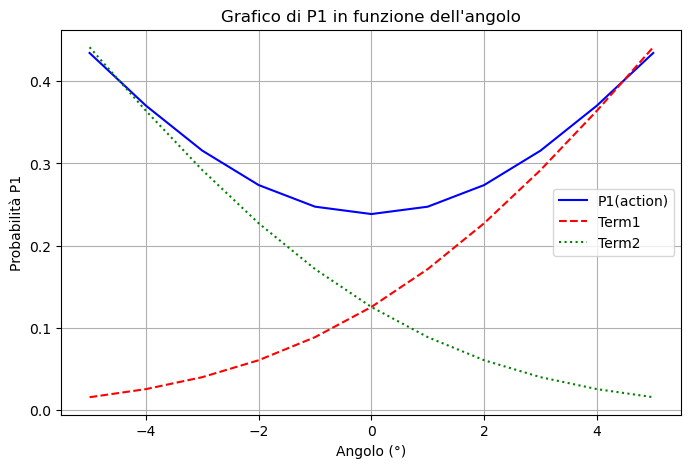

In [33]:
# P1 test
P1_values = []
term1_values = []
term2_values = []
for angle in testAnglesDeg:
    action = (20, angle) # Fixed velocity of 20 m/s
    P1_val, term1_val, term2_val = P1(action, kinematicModel, action[0]/4) # Standard deviation = velocity / 4
    P1_values.append(P1_val)
    term1_values.append(term1_val)
    term2_values.append(term2_val)
    
# Plotta il grafico
plt.figure(figsize=(8,5))
plt.plot(testAnglesDeg, P1_values, label="P1(action)", color="b", linestyle="-")
plt.plot(testAnglesDeg, term1_values, label="Term1", color="r", linestyle="--")
plt.plot(testAnglesDeg, term2_values, label="Term2", color="g", linestyle=":")

# Aggiungi etichette e titolo
plt.xlabel("Angolo (°)")
plt.ylabel("Probabilità P1")
plt.title("Grafico di P1 in funzione dell'angolo")
plt.legend()
plt.grid()

Value: 0.02771599057114864
Value: 0.024021227659678877
Value: 0.02075283261056816
Value: 0.018183991820402128
Value: 0.016541962244023926
Value: 0.015977096054529783
Value: 0.01654196224402393
Value: 0.018183991820402128
Value: 0.020752832610568157
Value: 0.024021227659678877
Value: 0.02771599057114864


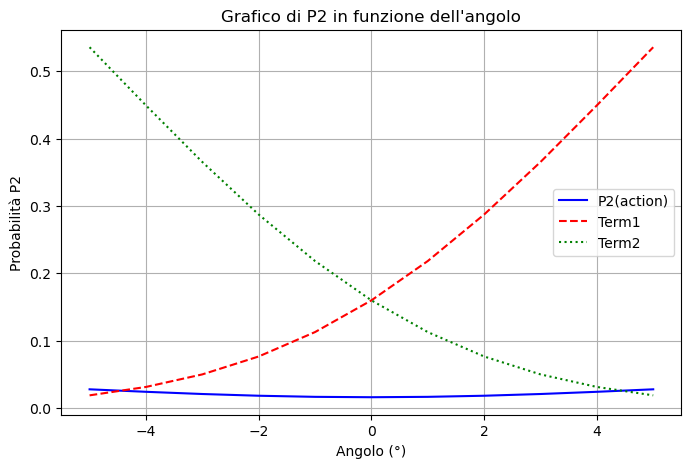

In [36]:
# P2 test
P2_values = []
term1_values = []
term2_values = []
for angle in testAnglesDeg:
    action = (25, angle) # Fixed velocity of 25 m/s
    P2_val, term1_val, term2_val = P2(action, kinematicModel, math.sqrt(action[0]/4 + 15)) # Standard deviation = sqrt(velocity / 4 + 15)
    P2_values.append(P2_val)
    term1_values.append(term1_val)
    term2_values.append(term2_val)
    
# Plotta il grafico
plt.figure(figsize=(8,5))
plt.plot(testAnglesDeg, P2_values, label="P2(action)", color="b", linestyle="-")
plt.plot(testAnglesDeg, term1_values, label="Term1", color="r", linestyle="--")
plt.plot(testAnglesDeg, term2_values, label="Term2", color="g", linestyle=":")

# Aggiungi etichette e titolo
plt.xlabel("Angolo (°)")
plt.ylabel("Probabilità P2")
plt.title("Grafico di P2 in funzione dell'angolo")
plt.legend()
plt.grid()

Value: 0.2849999513901844
Value: 0.28499997938077065
Value: 0.2849999914682685
Value: 0.28499999655648695
Value: 0.2849999986443401
Value: 0.28499999947944105
Value: 0.2849999986443401
Value: 0.28499999655648695
Value: 0.2849999914682685
Value: 0.28499997938077065
Value: 0.2849999513901844


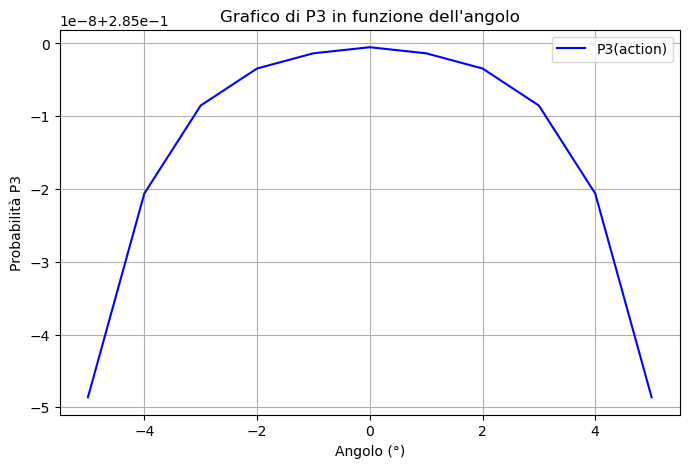

In [37]:
# P3 test
P3_values = []
for angle in testAnglesDeg:
    action = (25, angle)
    P3_val = P3(action, kinematicModel, action[0]/4)
    P3_values.append(P3_val)
    
# Plotta il grafico
plt.figure(figsize=(8,5))
plt.plot(testAnglesDeg, P3_values, label="P3(action)", color="b", linestyle="-")

# Aggiungi etichette e titolo
plt.xlabel("Angolo (°)")
plt.ylabel("Probabilità P3")
plt.title("Grafico di P3 in funzione dell'angolo")
plt.legend()
plt.grid()

Value: 0.014999999999964549
Value: 0.014999999999992499
Value: 0.014999999999998483
Value: 0.014999999999999706
Value: 0.014999999999999946
Value: 0.014999999999999989
Value: 0.014999999999999946
Value: 0.014999999999999706
Value: 0.014999999999998483
Value: 0.014999999999992499
Value: 0.014999999999964549


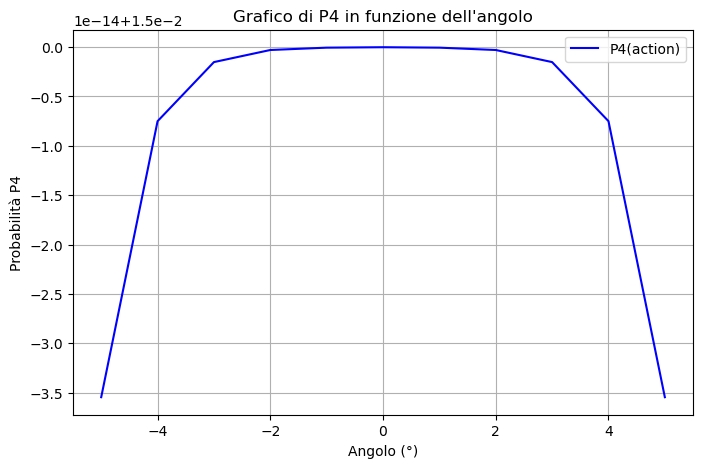

In [9]:
# P4 test
P4_values = []
for angle in testAnglesDeg:
    action = (25, angle)
    P4_val = P4(action, kinematicModel, math.sqrt(action[0]/4 + 15))
    P4_values.append(P4_val)
    
# Plotta il grafico
plt.figure(figsize=(8,5))
plt.plot(testAnglesDeg, P4_values, label="P4(action)", color="b", linestyle="-")

# Aggiungi etichette e titolo
plt.xlabel("Angolo (°)")
plt.ylabel("Probabilità P4")
plt.title("Grafico di P4 in funzione dell'angolo")
plt.legend()
plt.grid()

In [38]:
# Transition probabilities

# Transition from any state to G (good state)
def anyToG(action, environment):
    P1_val, _, _ = P1(action, environment, action[0]/4, False)
    P2_val, _, _ = P2(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False)
    # Term 1 is the probability of NOT going out of the road
    term1 = 1 - (P1_val + P2_val)
    # Term 2 is the probability of NOT risking a crash
    term2 = 1 - (P3(action, environment, action[0]/4, False) + P4(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False))
    return term1 * term2

# Transition from any state to X (out of road state)  
def anyToX(action, environment):
    P1_val, _, _ = P1(action, environment, action[0]/4, False)
    P2_val, _, _ = P2(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False)
    # Term 1 is the probability of going out of the road
    term1 = P1_val + P2_val
    # Term 2 is the probability of NOT risking a crash
    term2 = 1 - (P3(action, environment, action[0]/4, False) + P4(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False))
    return term1 * term2

# Transition from any state to I (risk of crash state)
def anyToI(action, environment):
    P1_val, _, _ = P1(action, environment, action[0]/4, False)
    P2_val, _, _ = P2(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False)
    # Term 1 is the probability of NOT going out of the road
    term1 = 1 - (P1_val + P2_val)
    # Term 2 is the probability of risking a crash
    term2 = P3(action, environment, action[0]/4, False) + P4(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False)
    return term1 * term2

# Transition from any state to XI (out of road and risk of crash state)
def anyToXI(action, environment):
    P1_val, _, _ = P1(action, environment, action[0]/4, False)
    P2_val, _, _ = P2(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False)
    # Term 1 is the probability of going out of the road
    term1 = P1_val + P2_val
    # Term 2 is the probability of risking a crash
    term2 = P3(action, environment, action[0]/4, False) + P4(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False)
    return term1 * term2

# Transition probabilities matrix for the given actions and states
# Each action is evaluated for all transition functions
def transitionProbabilitiesMatrix(actions, environment):
    transitions = [anyToG, anyToX, anyToI, anyToXI]
    transitionMatrix = np.array([[transition(action, kinematicModel) for transition in transitions] for action in actions])
    return transitionMatrix

In [ ]:
# Reward for staying at the center of the road (within Lmax * ratio)
def rewardCenterProbability(action, environment, ratio, show = True):
    
    # Term 1 is the probability that y < Lmax * ratio
    term1 = math.degrees(math.asin(((environment.Lmax * ratio) - environment.y) / action[0]))
    term1C = norm.cdf((1 / (math.sqrt(action[0]/4 + environment.sigmaC))) * (term1 - action[1] - environment.theta))
    term1 = norm.cdf((1 / (action[0]/4)) * (term1 - action[1] - environment.theta))
    #print(f"Term 1: {term1}")
    
    # Term 2 is the probability that y > -Lmax * ratio
    term2 = math.degrees(math.asin(((-environment.Lmax * ratio) - environment.y) / action[0]))
    term2C = norm.cdf((1 / (math.sqrt(action[0]/4 + environment.sigmaC))) * (term2 - action[1] - environment.theta))
    term2 = norm.cdf((1 / (action[0]/4)) * (term2 - action[1] - environment.theta))
    #print(f"Term 2: {term2}")
    
    # Combine the two probabilities (based on a mixture of road types (straight and curved))
    value = ((1 - environment.p1) * (term1 - term2)) + (environment.p1 * (term1C - term2C))
    if show:
        print(f"Value: {value}")
    return value

# Reward for maintaining the correct speed
def rewardSpeed(action, environment):
    # The closer the current speed (action[0]) is to the target speed (environment.l), the smaller the penalty.
    return -0.5 * (math.fabs(environment.l - action[0])) 

# Reward for staying at the correct distance
def rewardDistanceProbability(action, environment):
    # Probability of risking a crash in a straight road given an action 
    term1 = P3(action, environment, action[0] / 4, False)
    #Probability of risking a crash in a curved road given an action
    term2 = P4(action, environment, math.sqrt(action[0]/4 + environment.sigmaC), False)
    
    return term1 + term2 # Combined probability of risking a crash in both straight and curved road.

# Reward for going out of the road
def rewardOutOfRoadProbability(action, environment):
    # Probability of going out of a straight road given an action
    term1, _, _ = P1(action, environment, action[0]/4, False)
    # Probability of going out of a curved road given an action
    term2, _, _ = P2(action, environment, action[0]/4, False)
    return term1 + term2 

# Computes the total expected reward for an action
def expectedReward(action, environment, r1, r2, r3, r4, show = True):
    termR1 = r1 * rewardCenterProbability(action, environment, 0.5, False) # Reward for staying close to center
    #print(f"Term r1: {termR1}")
    termR2 = r2 * rewardCenterProbability(action, environment, 0.25, False) 
    #print(f"Term r2: {termR2}")
    rSpeed = rewardSpeed(action, environment) # Reward for maintaining the correct speed

    if show:
        print(f"Reward for action [{action[0]}, {action[1]}]: {round(termR1 + termR2 + rSpeed, 2)}")
    return termR1 + termR2 + rSpeed

# Adds additional safety-based criteria such as crash and off-road probabilities.
def expectedSafeReward(action, environment, r1, r2, r3, r4, r5, r6, show = True):
    termR1 = r1 * rewardCenterProbability(action, environment, 0.5, False)
    #print(f"Term r1: {termR1}")
    termR2 = r2 * rewardCenterProbability(action, environment, 0.25, False)
    #print(f"Term r2: {termR2}")
    rSpeed = rewardSpeed(action, environment)
    termR3 = r3 * (1 - rewardDistanceProbability(action, environment))
    #print(f"Term r3: {termR3}")
    termR4 = r4 * rewardDistanceProbability(action, environment) # Reward for risking a crash (r4 negaitve)
    #print(f"Term r4: {termR4}")
    termR5 = r5 * (1 - rewardOutOfRoadProbability(action, environment))
    termR6 = r6 * rewardOutOfRoadProbability(action, environment)
    if show:
        print(f"Reward for action [{action[0]}, {action[1]}]: {round(termR1 + termR2 + rSpeed + termR3 + termR4 + termR5 + termR6, 2)}")
    return termR1 + termR2 + rSpeed + termR3 + termR4 + termR5 + termR6

In [ ]:
# Reward coefficients 
r1 = 5
r2 = 10
r3 = 0
r4 = -50
r5 = 0
r6 = -50

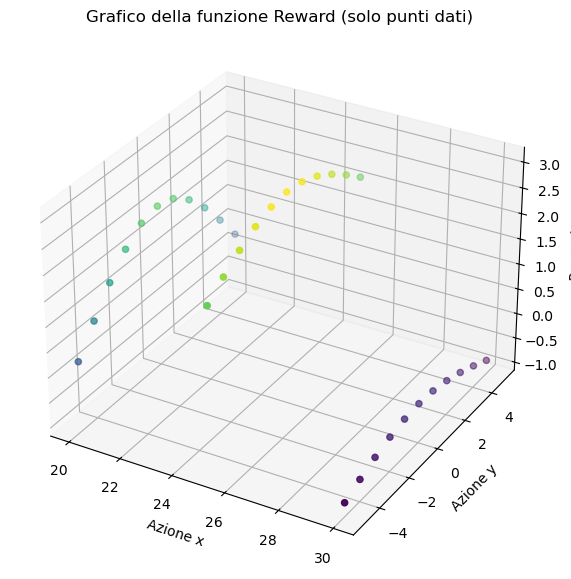

In [46]:
# Estrai i valori delle azioni
x_vals = [action[0] for action in testActions]
y_vals = [action[1] for action in testActions]
reward_values = [expectedReward(action, kinematicModel, r1, r2, r3, r4, False) for action in testActions]

# Creazione del grafico 3D con i punti reali
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_vals, y_vals, reward_values, c=reward_values, cmap="viridis", marker='o')

# Etichette
ax.set_xlabel("Azione x")
ax.set_ylabel("Azione y")
ax.set_zlabel("Reward")
ax.set_title("Grafico della funzione Reward (solo punti dati)")

plt.show()

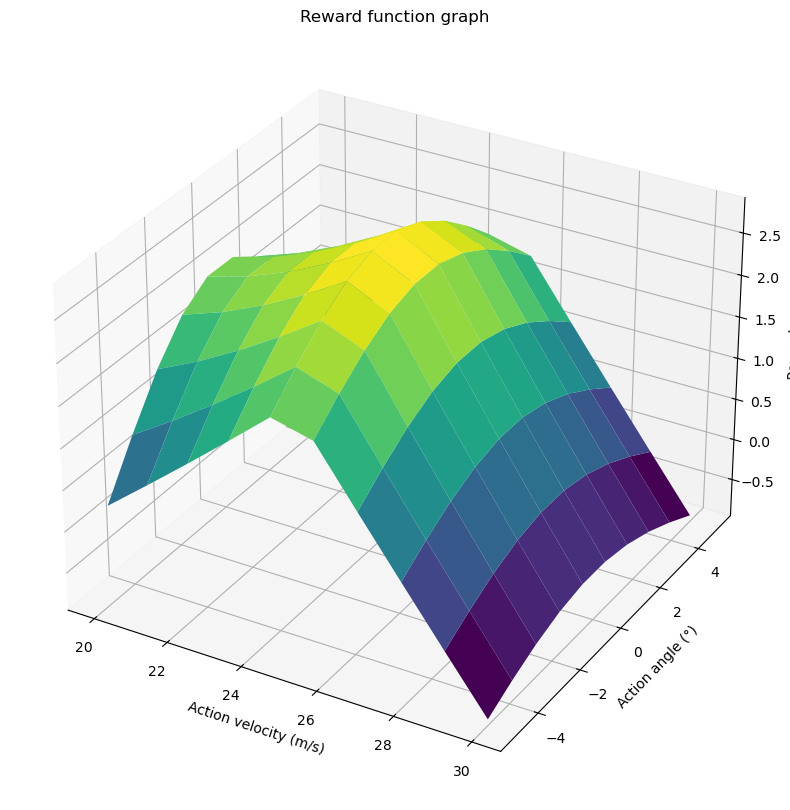

In [47]:
# Estrai i valori delle azioni
x_vals = [action[0] for action in testActions]
y_vals = [action[1] for action in testActions]
reward_values = [expectedReward(action, kinematicModel, r1, r2, r3, r4, False) for action in testActions]

# Creazione di una griglia di valori per X e Y
X, Y = np.meshgrid(np.linspace(min(x_vals), max(x_vals), 10),
                   np.linspace(min(y_vals), max(y_vals), 10))

# Calcoliamo il valore della funzione reward su questa griglia
Z = np.array([[expectedReward([X[i, j], Y[i, j]], kinematicModel, r1, r2, r3, r4, False) 
               for j in range(X.shape[1])] for i in range(X.shape[0])])

# Creazione del grafico 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis")

# Etichette
ax.set_xlabel("Action velocity (m/s)")
ax.set_ylabel("Action angle (°)")
ax.set_zlabel("Reward")
ax.set_title("Reward function graph")

plt.savefig("reward_function_graph.pdf")

plt.show()

In [28]:
import plotly.graph_objects as go
import numpy as np

# Assumiamo che x_vals, y_vals e reward_values siano già definiti
x_vals = [action[0] for action in testActions]
y_vals = [action[1] for action in testActions]
reward_values = [expectedReward(action, kinematicModel, r1, r2, r3, r4, False) for action in testActions]

# Creiamo una griglia per la superficie
x_vals = np.array(x_vals)
y_vals = np.array(y_vals)
z_vals = np.array(reward_values)

# Creiamo una meshgrid per la superficie
x_grid, y_grid = np.meshgrid(np.unique(x_vals), np.unique(y_vals))
z_grid = z_vals.reshape(len(np.unique(y_vals)), len(np.unique(x_vals)))

# Creiamo la superficie
fig = go.Figure(data=[go.Surface(
    x=x_grid,  # x-axis data (velocità)
    y=y_grid,  # y-axis data (angolo di sterzo)
    z=z_grid,  # z-axis data (reward values)
    colorscale='Viridis',  # colormap
    colorbar=dict(title="Reward")  # colorbar legend
)])

# Aggiorniamo il layout per aggiungere titoli e un titolo al grafico
fig.update_layout(
    scene=dict(
        xaxis_title="Velocità",  # x-axis title
        yaxis_title="Angolo di Sterzo",  # y-axis title
        zaxis_title="Reward"  # z-axis title
    ),
    title="Superficie della Funzione di Reward"
)

# Mostra il grafico interattivo
fig.show()

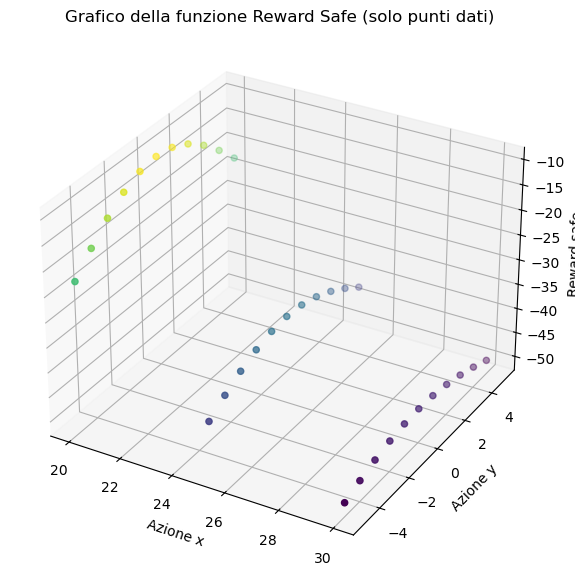

In [44]:
# Estrai i valori delle azioni
x_vals = [action[0] for action in testActions]
y_vals = [action[1] for action in testActions]
reward_values = [expectedSafeReward(action, kinematicModel, r1, r2, r3, r4, r5, r6, False) for action in testActions]

# Creazione del grafico 3D con i punti reali
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_vals, y_vals, reward_values, c=reward_values, cmap="viridis", marker='o')

# Etichette
ax.set_xlabel("Azione x")
ax.set_ylabel("Azione y")
ax.set_zlabel("Reward safe")
ax.set_title("Grafico della funzione Reward Safe (solo punti dati)")

plt.show()

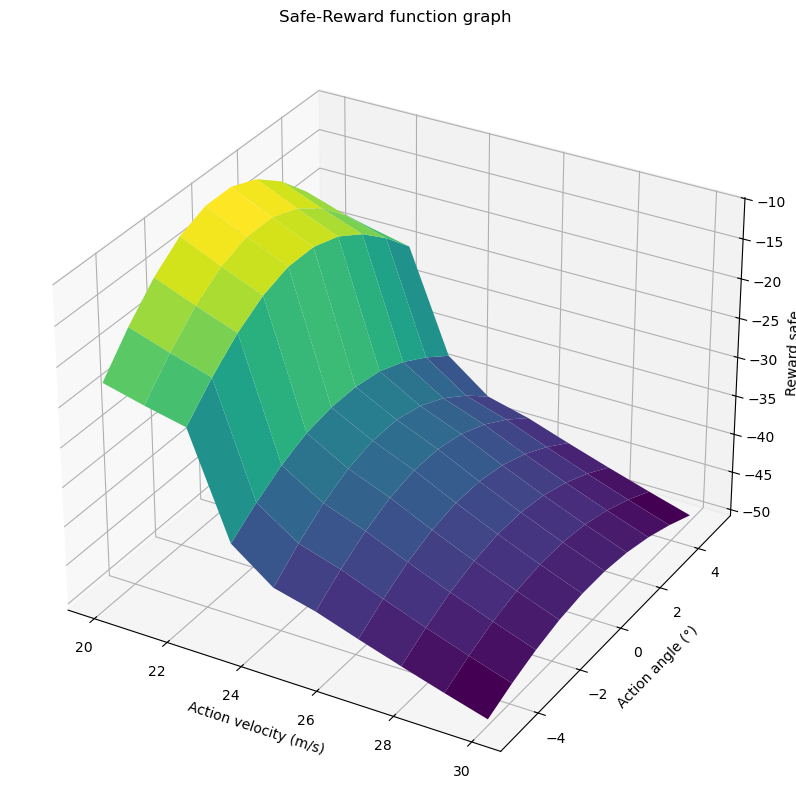

In [45]:
# Estrai i valori delle azioni
x_vals = [action[0] for action in testActions]
y_vals = [action[1] for action in testActions]
reward_values = [expectedSafeReward(action, kinematicModel, r1, r2, r3, r4, r5, r6, False) for action in testActions]

# Creazione di una griglia di valori per X e Y
X, Y = np.meshgrid(np.linspace(min(x_vals), max(x_vals), 10),
                   np.linspace(min(y_vals), max(y_vals), 10))

# Calcoliamo il valore della funzione reward su questa griglia
Z = np.array([[expectedSafeReward([X[i, j], Y[i, j]], kinematicModel, r1, r2, r3, r4, r5, r6, False) 
               for j in range(X.shape[1])] for i in range(X.shape[0])])

# Creazione del grafico 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis")

# Etichette
ax.set_xlabel("Action velocity (m/s)")
ax.set_ylabel("Action angle (°)")
ax.set_zlabel("Reward safe")
ax.set_title("Safe-Reward function graph")

plt.savefig("safe-reward_function_graph.pdf")

plt.show()

In [29]:
import plotly.graph_objects as go
import numpy as np

# Assumiamo che x_vals, y_vals e reward_values siano già definiti
x_vals = [action[0] for action in testActions]
y_vals = [action[1] for action in testActions]
reward_values = [expectedSafeReward(action, kinematicModel, r1, r2, r3, r4, r5, r6, False) for action in testActions]

# Creiamo una griglia per la superficie
x_vals = np.array(x_vals)
y_vals = np.array(y_vals)
z_vals = np.array(reward_values)

# Creiamo una meshgrid per la superficie
x_grid, y_grid = np.meshgrid(np.unique(x_vals), np.unique(y_vals))
z_grid = z_vals.reshape(len(np.unique(y_vals)), len(np.unique(x_vals)))

# Creiamo la superficie
fig = go.Figure(data=[go.Surface(
    x=x_grid,  # x-axis data (velocità)
    y=y_grid,  # y-axis data (angolo di sterzo)
    z=z_grid,  # z-axis data (reward values)
    colorscale='Viridis',  # colormap
    colorbar=dict(title="Reward")  # colorbar legend
)])

# Aggiorniamo il layout per aggiungere titoli e un titolo al grafico
fig.update_layout(
    scene=dict(
        xaxis_title="Velocità",  # x-axis title
        yaxis_title="Angolo di Sterzo",  # y-axis title
        zaxis_title="Reward"  # z-axis title
    ),
    title="Superficie della Funzione di Reward"
)

# Mostra il grafico interattivo
fig.show()